## Ebola infected Macaque Sample Composition Trajectory Identification

```
Indices:

- c cell type
- g genes
- m samples
- k deformation polynomial degree
```

In [1]:
import os
import pickle5
import numpy as np
import pandas as pd
#import matplotlib.pylab as plt
import matplotlib
import matplotlib.pyplot
from typing import Dict
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from typing import List, Dict
from boltons.cacheutils import cachedproperty
from pyro.distributions.torch_distribution import TorchDistribution, TorchDistributionMixin
from torch.distributions.utils import probs_to_logits, logits_to_probs, broadcast_all, lazy_property
from torch.distributions import constraints
from numbers import Number
import pyro.distributions as dist
import anndata
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline

In [2]:
from time_deconv.time_deconv import *

## Parameter Configuration

In [3]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

## Train Model

In [4]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [5]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [7]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'overdispersed_bulk_and_high_sc' #'overdispersed_bulk'
)

feature selection method: overdispersed_bulk_and_high_sc


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.1044e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


selected 3356 genes


In [8]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 10,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=10_000, verbose=True, log_frequency=1000)

/mnt/disk2/nbarkas/deconvolution_method/temporal-rna-seq-deconvolution/time_deconv/time_deconv.py:216: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "x_mg": torch.tensor(dataset.bulk_raw_gex_mg, device=device, dtype=dtype),


[iteration: 0]   loss: 30370712.89
[iteration: 1000]   loss: 8791897.43
[iteration: 2000]   loss: 3669905.31
[iteration: 3000]   loss: 2132536.68
[iteration: 4000]   loss: 1548554.90
[iteration: 5000]   loss: 1278487.37
[iteration: 6000]   loss: 1140765.04
[iteration: 7000]   loss: 1067802.86
[iteration: 8000]   loss: 1028836.45
[iteration: 9000]   loss: 1008066.40


## Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

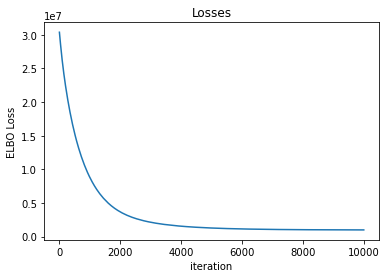

In [10]:
pseudo_time_reg_deconv.plot_loss()

In [11]:
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)

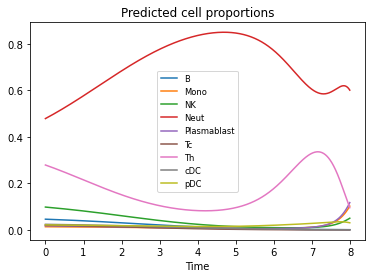

In [12]:
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

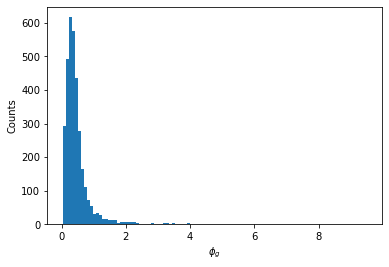

In [13]:
pseudo_time_reg_deconv.plot_phi_g_distribution()

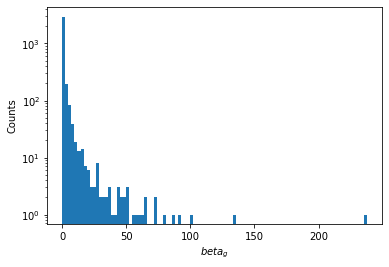

In [14]:
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')